In [3]:
from lib.data import Mimic2
import numpy as np
from lib.model import LR
from lib.train import Trainer, prepareData
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.regularization import eye_loss, wridge, wlasso, lasso, ridge, owl
from sklearn.metrics import accuracy_score
from lib.utility import get_y_yhat, model_auc
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from main import random_risk_exp, expert_feature_only_exp, reg_exp
import glob
from sklearn.externals import joblib
from pandas import DataFrame

# MIMIC2 

We use MIMIC2 dataset to predict mortality.

data preprocess:
1. For each time series, we compute the mean, min, and max
2. We use the features of scores in Jean-roger et al. (A simplified acute physiology score for ICU patients) as $r$
3. standardize each feature to have zero mean and unit variance

We are using physionet 2012 challenge with no test set. We use a stratified random split of the trianing data for seta data. Our result on both AUC and score1 is comparable to other published results (each model is train for 300 epoch).

In [4]:
m = Mimic2(mode='total', expert_feature_only=False)

In [5]:
m.x

,ALP_max,ALP_mean,ALP_min,ALT_max,ALT_mean,ALT_min,AST_max,AST_mean,AST_min,Age,...,HR_worst,K_worst,MechVent_worst,NISysABP_worst,Na_worst,RespRate_worst,SysABP_worst,Temp_worst,Urine_worst,WBC_worst
0,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,54.0,...,58.000000,4.400000,12.0,157.000000,137.0,12.000000,115.134094,35.100000,2470.000000,11.2
1,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,76.0,...,80.000000,4.300000,49.0,122.469331,139.0,21.725615,66.000000,34.500000,3474.000000,7.4
2,127.000000,116.000000,105.000000,91.000000,83.000000,75.000000,235.0,199.500000,164.000000,44.0,...,57.000000,8.600000,49.0,150.000000,137.0,21.725615,115.134094,39.000000,2910.000000,3.7
3,105.000000,105.000000,105.000000,12.000000,12.000000,12.000000,15.0,15.000000,15.000000,68.0,...,57.000000,4.000000,12.0,102.000000,140.0,12.000000,115.134094,35.100000,1400.000000,8.8
4,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,88.0,...,67.000000,6.000000,12.0,156.000000,140.0,26.000000,115.134094,35.800000,1196.000000,3.8
5,101.000000,101.000000,101.000000,60.000000,52.500000,45.000000,162.0,104.500000,47.000000,64.0,...,71.000000,3.800000,49.0,73.000000,137.0,21.725615,115.134094,35.800000,2850.000000,24.0
6,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,68.0,...,50.000000,3.400000,12.0,218.000000,139.0,11.000000,115.134094,35.800000,1366.000000,6.2
7,47.000000,47.000000,47.000000,46.000000,46.000000,46.000000,82.0,82.000000,82.000000,78.0,...,62.000000,3.900000,49.0,122.469331,141.0,21.725615,76.000000,35.600000,973.000000,20.4
8,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,64.0,...,120.000000,3.900000,12.0,106.000000,139.0,44.000000,115.134094,36.800000,700.000000,15.2
9,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,74.0,...,67.000000,4.600000,49.0,122.469331,141.0,21.725615,78.000000,34.800000,2610.000000,9.0


In [6]:
r = Variable(torch.FloatTensor(list(map(lambda name: 1 if 'worst' in name else 0, m.x.columns))))

d = r.size(0)
train_data = TensorDataset(*map(lambda x: x.data, prepareData(m.xtrain, m.ytrain)))
data = DataLoader(train_data, batch_size=4000, shuffle=True, num_workers=1)

valdata = TensorDataset(*map(lambda x: x.data, prepareData(m.xval, m.yval)))
valdata = DataLoader(valdata, batch_size=4000, shuffle=True)

n_output = 2 # binary classification task                                                                                                                                          
model = LR(d, n_output)                                                                                                                                                            
learning_rate = 0.001                                                                                                                                                               

reg_parameters = model.i2o.weight
t = Trainer(model, lr=learning_rate, risk_factors=r, alpha=0.0, # 0.01 for eye
            regularization=eye_loss, reg_parameters=reg_parameters)  
losses, vallosses = t.fit(data, n_epochs=10, print_every=1, valdata=valdata)                                                                                                                                                       

def model_acc(model, x, y):                                                                                                                                                        
    x, _ = prepareData(x, y)                                                                                                                                                       
    yhat = np.argmax(model(x).data.numpy(), 1)                                                                                                                                     
    return accuracy_score(y, yhat)                                                                                                                                                 

print('train auc', model_auc(model, data) )
print('val auc', model_auc(model, valdata)) 

10.00% (0m 0s) 0.0003 0.62600.6548
20.00% (0m 0s) 0.0003 0.63970.6702
30.00% (0m 0s) 0.0003 0.65320.6834
40.00% (0m 1s) 0.0003 0.66610.6977
50.00% (0m 1s) 0.0003 0.67760.7099
60.00% (0m 1s) 0.0003 0.68810.7217
70.00% (0m 2s) 0.0003 0.69790.7330
80.00% (0m 2s) 0.0003 0.70630.7427
90.00% (0m 2s) 0.0003 0.71370.7517
100.00% (0m 2s) 0.0003 0.72040.7601
train auc 0.720409621338
val auc 0.760136341986


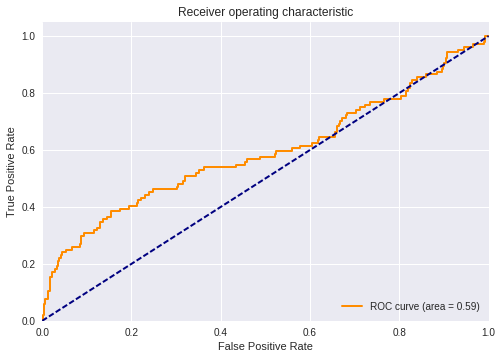

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from lib.utility import plotAUC
plotAUC(m, model, valdata)

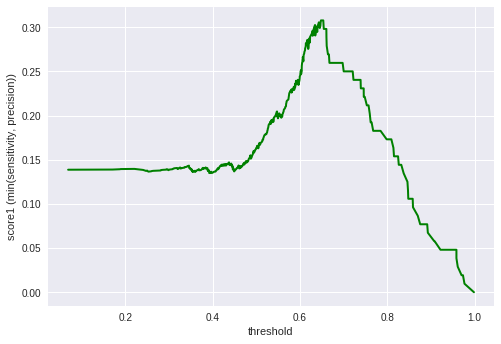

score1 on validation set is 0.307692307692


In [21]:
from lib.utility import sweepS1

threshold, score1 = sweepS1(model, valdata, plot=True, mode='s1')
print('score1 on validation set is', score1)

In [7]:
from sklearn.metrics import average_precision_score

def calcAP(ytrue, ypred):
    return average_precision_score(ytrue, np.abs(ypred))

ap = calcAP(r.data.numpy(), (reg_parameters[1] - reg_parameters[0]).data.numpy())
print('average precision is', ap)

average precision is 0.171774366438


In [8]:
print('average precision is %.4f' % calcAP(r.data.numpy(), (reg_parameters[1] - reg_parameters[0]).data.numpy()))
print('val auc is %.4f' % model_auc(model, valdata)) 

average precision is 0.1718
val auc is 0.6435


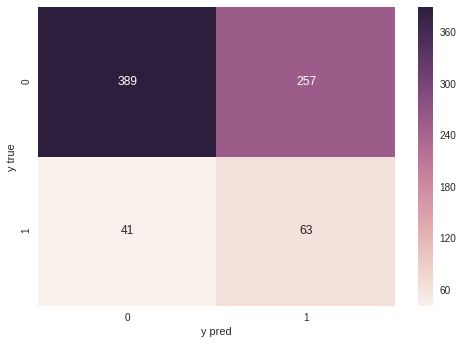

In [9]:
from sklearn.metrics import confusion_matrix

y_test, y_score = get_y_yhat(model, valdata)
yhat = np.argmax(y_score, 1)
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm, annot=True, fmt='d')
sns.set(font_scale=1)
plt.ylabel('y true')
plt.xlabel('y pred')
plt.show()
tn, fp, fn, tp = cm.ravel()

In [10]:
print(m.ytrain.sum() / m.ytrain.shape[0])
print(m.yval.sum() / m.yval.shape[0])

0.138666666667
0.138666666667


We compute the same statistics as for Cdiff. 

Observations:
1. expert only ridge logistic regression performs considerably worse than other methods (0.74 vs ~0.81)
2. random feature eye has a large AP while maintaining a good auc means that almost all features of size 16 has comparable predictive power
3. of all high auc method, eye has the highest sparsity

In [37]:
# showing that pytorch dataloader has race condition
from lib.parallel_run import map_parallel
from multiprocessing import Pool

def t(i):
    name = 'random_risk_eye^0.01'
    model = torch.load('models/' + name + '.pt')
#     for x, y in valdata:
#         break
    x = torch.from_numpy(np.ones((3, 131))).type(torch.FloatTensor)
    x = Variable(x)
    a = model.i2o(x)
    b = torch.nn.functional.softmax(a, dim=1)
    b = model.softmax(a)
    print(i, model.forward(x).data.size())

    print('done', i)


tasks = list(range(10))
#Pool.starmap(t, tasks)
map_parallel(t, tasks)
    

0/10 done
0/10 done


KeyboardInterrupt: 

# show result

In [33]:
raw_data = []
for fn in glob.glob('models/test*.pkl'):
    name = fn.split('/')[-1].split('.pkl')[0]    
    name, alpha = name.split('^')
    if 'test' in name: name = name[4:]+'*'
    auc, ap, s1, sp = joblib.load(fn)
    raw_data.append([name, alpha, auc, ap, s1, sp])
df = DataFrame(data=raw_data, columns=['method name', 'alpha', 'auc', 'ap', 'min(recall, precision)', 'sparsity'])

In [34]:
df.sort_values(['auc'], ascending=False)

,method name,alpha,auc,ap,"min(recall, precision)",sparsity
4,lasso*,0.01,0.819286,0.134314,0.434783,0.770992
7,wlasso*,0.01,0.814192,0.320555,0.421429,0.778626
3,random_risk_eye*,0.001,0.813082,0.198531,0.427536,0.427481
2,eye_loss*,0.01,0.808997,0.636979,0.427536,0.809160
6,wridge3*,0.1,0.805130,0.642329,0.457746,0.076336
0,owl*,0.0001,0.798766,0.109197,0.420290,0.030534
1,enet*,0.1,0.764997,0.129404,0.373333,0.946565
5,expert_only_ridge*,0.1,0.738626,1.000000,0.368056,0.000000
